# Chapter7
## Model Performance and Validation

In [1]:
import os, sys
import numpy as np
from math import floor, ceil
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D
from tqdm import tqdm
import h5py
# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))
from sample import Sample
from dataset import Dataset
from database import Database
from dataset_simulation import DatasetSimulation
from cfar_detector import CFARDetector
from nn_detector import NeuralNetworkDetector
from yolo_detector import YOLODetector
from cfar_detector_generator import CFARDetectorGenerator


dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
result_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','results', 'awdEvents1')
dataset_sim_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'simulations', 'simple' ,'whistler')
site = 'marion'
t_res, f_res = 0.006395061728395062, 0.15503875968992248
database = Database(dataset_loc, database_loc, site)
cfar_detector_gen = CFARDetectorGenerator(dataset_loc, database_loc, dataset_sim_loc, result_loc, site, t_res, f_res)

linewidth = 2
font_title = 32
font_legend = 20
font_label = 24
font_ticks = 18
font = [font_title, font_legend, font_label, font_ticks, linewidth] # [None]*5

In [2]:
files = database.get_train()

### Cross-Correlation using Whistler Kernel (CCWK)

2013-05-18UT13:50:03.15432156.marion.vr2
[2.1, 2.3, 2.8]
[0.1, 2.4, 2.5]


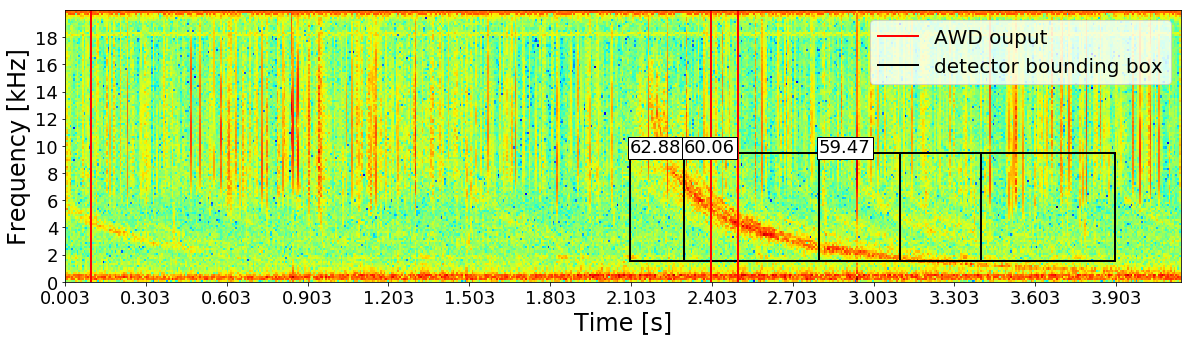

In [27]:
file = np.random.choice(files)
# file = '2013-07-19UT04:14:42.00291922.marion.vr2'
file = '2013-05-18UT13:50:03.15432156.marion.vr2'
# file = '2013-06-09UT09:29:32.01054609.marion.vr2'
sample = CFARDetector(dataset_loc, site, file)

## None
N,G,k,T1,T2,X_dB = 10,5,13,5,7,0.3
pfa = (1/(1+((10**(X_dB/10))/(2*N))))**(2*N)
transforms, transforms_params = ['slice',None,'scale'], [[1.5,9.5],[None],[0,1]]

# # Zscore [1.5,9.5]
# N,G,k,Ts,Tl,X_dB = 12,10,13,5,3,0.5
# pfa = (1/(1+((10**(X_dB/10))/(2*N))))**(2*N)
# transforms, transforms_params = ['slice','zscore','scale'], [[1.5,9.5],[None],[0,1]]

# # Zscore [4.5,11.5]
# N,G,k,Ts,Tl,X_dB = 15,7,15,2,7,0.7
# pfa = (1/(1+((10**(X_dB/10))/(2*N))))**(2*N)
# transforms, transforms_params = ['slice','zscore','scale'], [[1.5,9.5],[None],[0,1]]

# Linear Detrend [1.5,9.5]
# N,G,k,Ts,Tl,X_dB = 12,10,13,8,5,0.4
# pfa = (1/(1+((10**(X_dB/10))/(2*N))))**(2*N)
# transforms, transforms_params = ['slice','detrend','scale'], [[1.5,9.5],['linear'],[0,1]]

kernel = sample.load_kernel('sim', [0.35,80,1])
time_err = 1
print(file)
output = [o[0] for o in sample.detection_starting_locations_final(transforms,transforms_params, kernel, 'fusion_cfar', [N,G,k,T1,T2,pfa], threshold=0, time_err=time_err)]
print(output)
awd_output = [awd[0] for awd in sample.awda_whistlers(time_err=time_err)[0]]
print(awd_output)
bboxes = sample.detection_bounding_boxes(transforms,transforms_params, kernel, 'fusion_cfar', [N,G,k,T1,T2,pfa], threshold=0, time_err=time_err, duration=True)
freq_size = 4
sample.spectrogram_with_axis(log10=True)
# sample.apply_transform(['zscore'],[None])
sample.set_figsize(freq_size*sample.get_time_freq_ratio(dec=0), freq_size)

# plt.figure(figsize=(sample.get_figsize()[0],5))
# for a in awd_output:
#     plt.axvline(a-0.2, color='r', linewidth=font[-1])
# for o in output:
#     plt.axvline(o, color='k', linewidth=font[-1])
# plt.pcolormesh(sample.get_time(),sample.get_freq(),sample.get_spectrogram(), cmap='jet')
# plt.xticks(np.arange(sample.get_time()[0], sample.get_time()[-1], .3), fontsize=font[3])
# plt.yticks(np.arange(sample.get_freq()[0], sample.get_freq()[-1], 2), fontsize=font[3])
# legend = [Line2D([0], [0], color='r', lw=font[-1], label='AWD ouput'),
#           Line2D([0], [0], color='k', lw=font[-1], label='detector ouput')]
# plt.legend(handles=legend,fontsize=font[1])
# plt.xlabel('Time [s]', fontsize=font[2])
# plt.ylabel('Frequency [kHz]', fontsize=font[2])
# plt.show()

plt.figure(figsize=(sample.get_figsize()[0],5))
for a in awd_output:
    plt.axvline(a, color='r', linewidth=font[-1])
for bbox in bboxes:
    c,x1,x2,y1,y2 = bbox
    color = 'k'
    rect = Rectangle((x1,y1), x2-x1, y2-y1, linewidth=font[-1], edgecolor=color, facecolor='none')
    plt.text(x1,y2,'%.2f'%c, fontsize=font[-2], bbox={'facecolor':'white', 'pad':2, 'ec':color})
    plt.gca().add_patch(rect)
plt.pcolormesh(sample.get_time(),sample.get_freq(),sample.get_spectrogram(), cmap='jet')
plt.xticks(np.arange(sample.get_time()[0], sample.get_time()[-1], .3), fontsize=font[3])
plt.yticks(np.arange(sample.get_freq()[0], sample.get_freq()[-1], 2), fontsize=font[3])
legend = [Line2D([0], [0], color='r', lw=font[-1], label='AWD ouput'),
          Line2D([0], [0], color='k', lw=font[-1], label='detector bounding box')]
plt.legend(handles=legend,fontsize=font[1])
plt.xlabel('Time [s]', fontsize=font[2])
plt.ylabel('Frequency [kHz]', fontsize=font[2])
plt.show()

In [ ]:
2013-07-11UT00:54:42.92451938.marion.vr2
2013-07-11UT01:11:03.86531938.marion.vr2
        2013-06-27UT22:04:56.58211922.marion.vr2

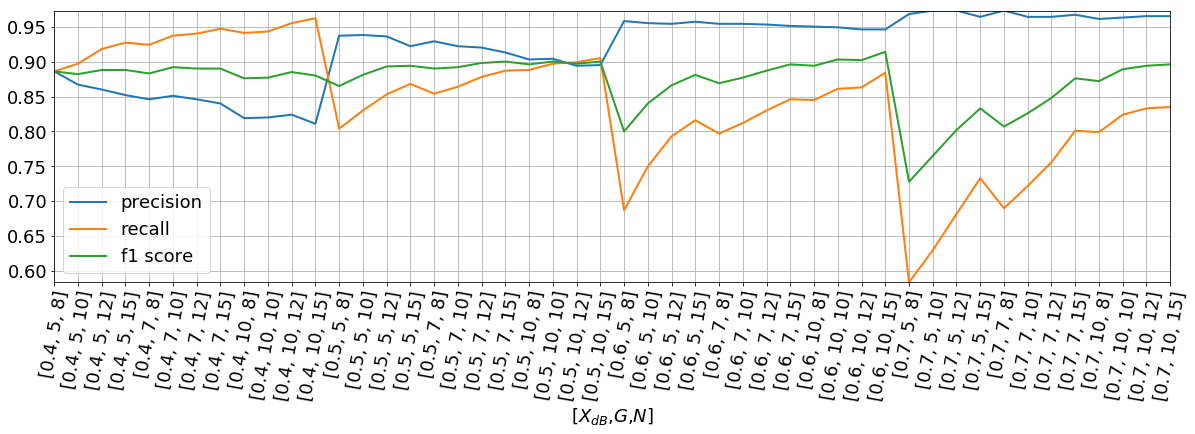

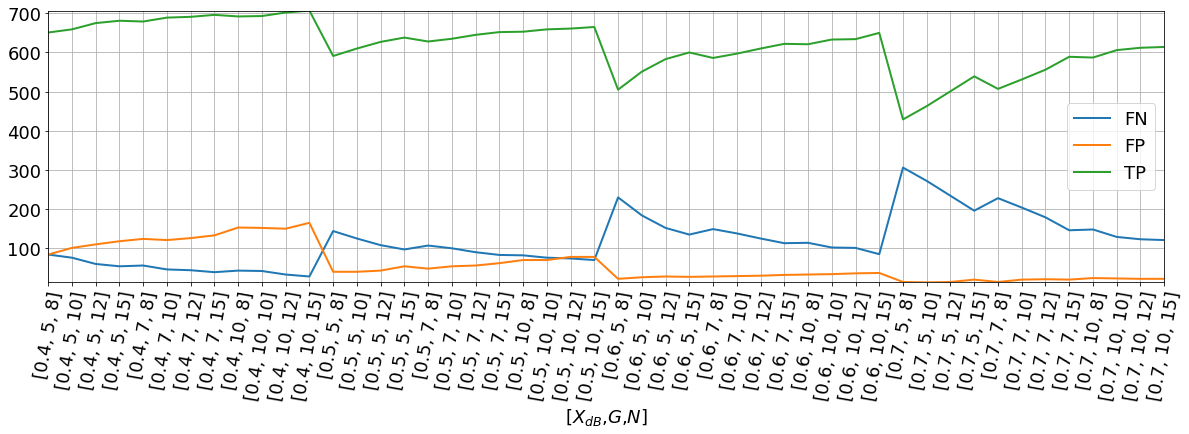

In [89]:
n = 200
f_min, f_max = 1.5, 9.5
N,G,k,Ts,Tl,X_dB = 10,7,0,0,0,0.5
# N,G,k,Ts,Tl,X_dB = 10,7,9,0,0,0.5

# for N in [8,10,12,15]:
#     for G in [5,7,10]:
#         for X_dB in [0.4,0.5,0.6,0.7]:
#             cfar_detector_gen.dataset_cross_correlation_gen(transforms='zscore', transforms_params=None, f_min=f_min, f_max=f_max, 
#                                            An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
#                                            train=True, n=n)
x_axis = []
recall, precision, f1_score = [],[],[]
TP,FP, FN = [],[],[]
results = {}
# for X_dB in [0.4,0.5,0.6,0.7]:
#     for G in [5,7,10]:
#         for N in [8,10,12,15]:
#             print([N,G,X_dB])
for X_dB in [0.4,0.5,0.6,0.7]:
    for G in [5,7,10]:
        for N in [8,10,12,15]:
            data = cfar_detector_gen.dataset_cross_correlation_load(transforms='zscore', transforms_params=None, f_min=f_min, f_max=f_max, 
                                           An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
                                           train=True, n=n)
            confusion_matrix = data['confusion matrix']
            x_axis.append([X_dB,G,N])
            results[str([X_dB,G,N])]=confusion_matrix
            TP.append(confusion_matrix[0])
            FP.append(confusion_matrix[1])
            FN.append(confusion_matrix[2])
            performance = cfar_detector_gen.performance(confusion_matrix)
            recall.append(performance['recall'])
            precision.append(performance['precision'])
            f1_score.append(performance['f1 score'])
#             print(performance)
plt.figure(figsize=(20,5))
plt.plot(precision,linewidth=font[-1])
plt.plot(recall,linewidth=font[-1])
plt.plot(f1_score,linewidth=font[-1])
plt.xticks(list(range(len(x_axis))),x_axis, rotation=80, fontsize=font[3])
plt.yticks(fontsize=font[3])
plt.legend(['precision','recall','f1 score'], fontsize=font[3])
plt.xlabel('[$X_{dB}$,$G$,$N$]', fontsize=font[3])
plt.autoscale(tight=True)
plt.grid(True)
plt.show()
plt.figure(figsize=(20,5))
plt.plot(FN,linewidth=font[-1])
plt.plot(FP,linewidth=font[-1])
plt.plot(TP,linewidth=font[-1])
plt.xticks(list(range(len(x_axis))),x_axis, rotation=80, fontsize=font[3])
plt.yticks(fontsize=font[3])
plt.legend(['FN','FP','TP'], fontsize=font[3])
plt.xlabel('[$X_{dB}$,$G$,$N$]', fontsize=font[3])
plt.autoscale(tight=True)
plt.grid(True)
plt.show()

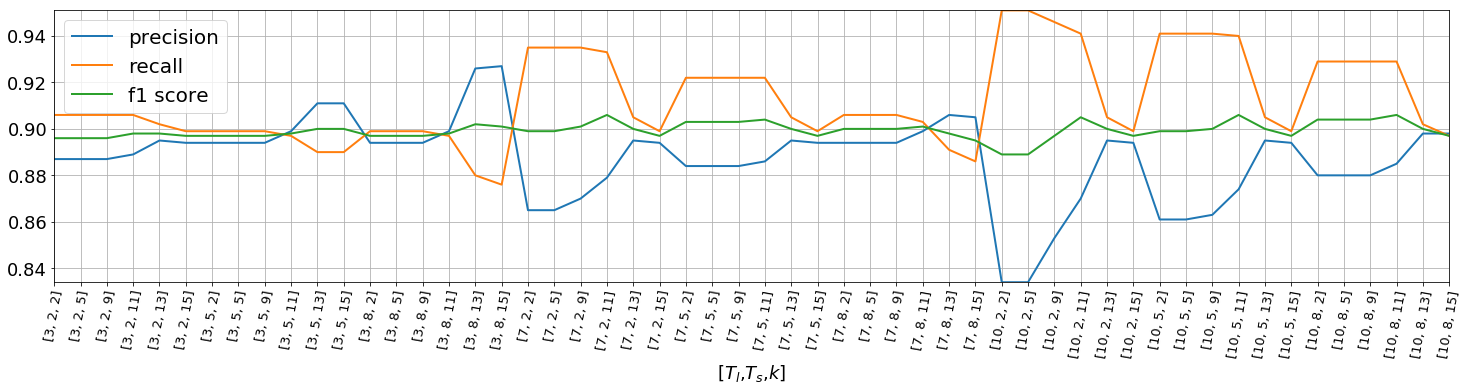

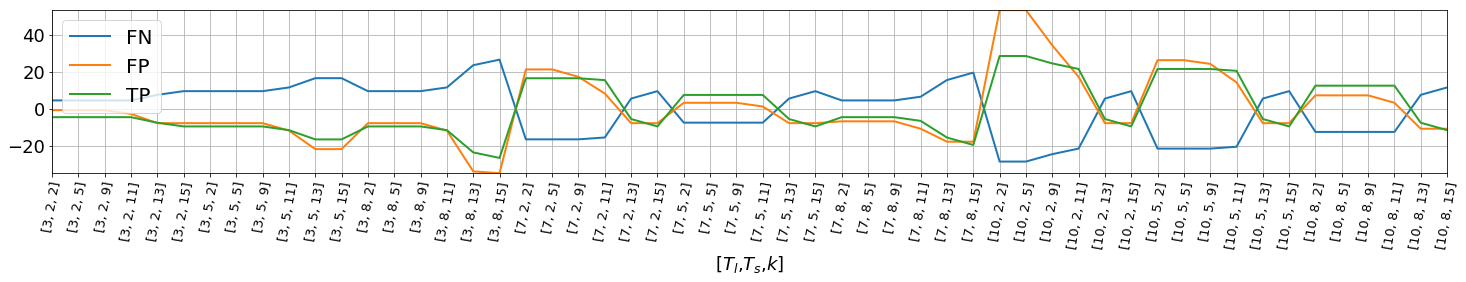

In [4]:
n = 200
f_min, f_max = 1.5, 9.5
N,G,k,Ts,Tl,X_dB = 12,10,0,0,0,0.5

# for k in [2, 5,9,11,13,15]:
#     for Ts in [0,2,5,8]:
#         for Tl in [0,3,7,10]:
#             cfar_detector_gen.dataset_cross_correlation_gen(transforms='zscore', transforms_params=None, f_min=f_min, f_max=f_max, 
#                                            An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
#                                            train=True, n=n)
x_axis = []
recall, precision, f1_score = [],[],[]
TP,FP, FN = [],[],[]
for Tl in [3,7,10]:
    for Ts in [2,5,8]:
        for k in [2, 5,9,11,13,15]:
            x_axis.append([Tl,Ts,k])
            data = cfar_detector_gen.dataset_cross_correlation_load(transforms='zscore', transforms_params=None, f_min=f_min, f_max=f_max, 
                                           An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
                                           train=True, n=n)
            confusion_matrix = data['confusion matrix']
            TP.append(confusion_matrix[0])
            FP.append(confusion_matrix[1])
            FN.append(confusion_matrix[2])
            performance = cfar_detector_gen.performance(confusion_matrix)
            recall.append(performance['recall'])
            precision.append(performance['precision'])
            f1_score.append(performance['f1 score'])
TP, FP, FN = np.array(TP),np.array(FP),np.array(FN)
TP, FP, FN = TP-TP.mean(),FP-FP.mean(),FN-FN.mean()

plt.figure(figsize=(25,5))
plt.plot(precision,linewidth=font[-1])
plt.plot(recall,linewidth=font[-1])
plt.plot(f1_score,linewidth=font[-1])
plt.xticks(list(range(len(x_axis))),x_axis, rotation=80, fontsize=font[3]-5)
plt.yticks(fontsize=font[3])
plt.legend(['precision','recall','f1 score'], fontsize=font[1])
plt.grid(True)
plt.autoscale(tight=True)
plt.xlabel('[$T_l$,$T_s$,$k$]', fontsize=font[3])
plt.show()
plt.figure(figsize=(25,3))
plt.plot(FN,linewidth=font[-1])
plt.plot(FP,linewidth=font[-1])
plt.plot(TP,linewidth=font[-1])
plt.xticks(list(range(len(x_axis))),x_axis, rotation=80, fontsize=font[3]-5)
plt.yticks(fontsize=font[3])
plt.legend(['FN','FP','TP'], fontsize=font[1])
plt.autoscale(tight=True)
plt.xlabel('[$T_l$,$T_s$,$k$]', fontsize=font[3])
plt.grid(True)
plt.show()

In [43]:
n = None
f_min, f_max = 1.5, 9.5
N,G,k,Ts,Tl,X_dB = 12,10,13,5,3,0.5
train = False
for train in [True, False]:
    cfar_detector_gen.dataset_cross_correlation_gen(transforms='zscore', transforms_params=None, f_min=f_min, f_max=f_max, 
                                               An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
                                               train=train, n=n)
    data = cfar_detector_gen.dataset_cross_correlation_load(transforms='zscore', transforms_params=None, f_min=f_min, f_max=f_max, 
                                               An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
                                               train=train, n=n)
    confusion_matrix = data['confusion matrix']
    performance = cfar_detector_gen.performance(confusion_matrix)
    print(confusion_matrix)
    print(performance)

results = data['results']
def function(results):
    new_results = results.copy()
    for key in new_results.keys():
        data = results[key]
        new_results[key] = [len(data[0]),len(data[1]),len(data[2]),len(data[3])]
    files = list(new_results.keys())
    data = np.array(list(new_results.values()))
    return files, data
f,d = function(results)
# print(results[f[0]],f[0],d[0])
# arg = np.intersect1d(np.argwhere(d[:,1]>0),np.argwhere(d[:,2]>0))
# print(len(arg))
# ix = arg[44]
# print(f[ix],results[f[ix]])

(zscore,None)_(1.5,9.5)_(0.35,80,1)_(12,10,13,5,3,0.5)_(True,None,1).corr already exists
[4578, 557, 540, 0]
{'recall': 0.894, 'precision': 0.892, 'f1 score': 0.893, 'g measure': 0.893, 'false alarm': 0.108, 'misdetection': 0.106}
(zscore,None)_(1.5,9.5)_(0.35,80,1)_(12,10,13,5,3,0.5)_(False,None,1).corr already exists
[2331, 242, 247, 0]
{'recall': 0.904, 'precision': 0.906, 'f1 score': 0.905, 'g measure': 0.905, 'false alarm': 0.094, 'misdetection': 0.096}


**Frequency Range**

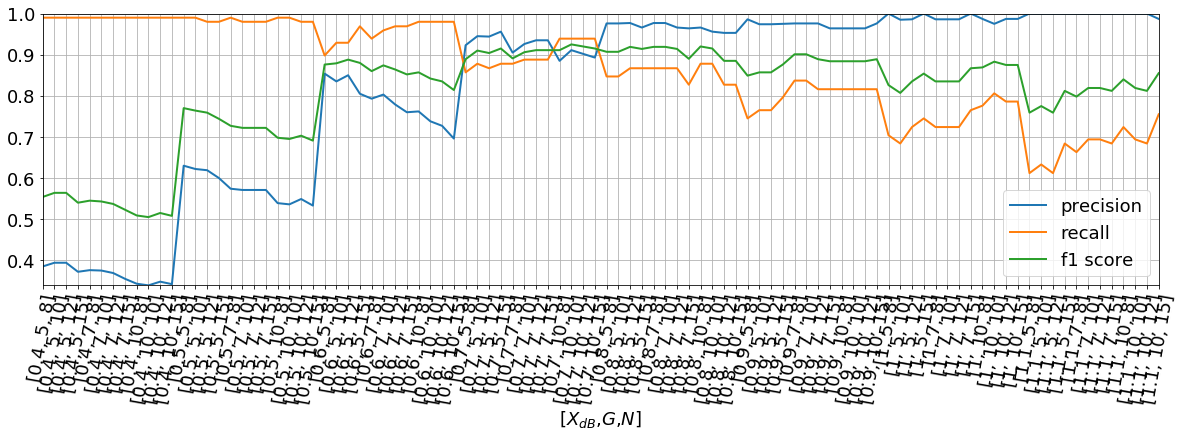

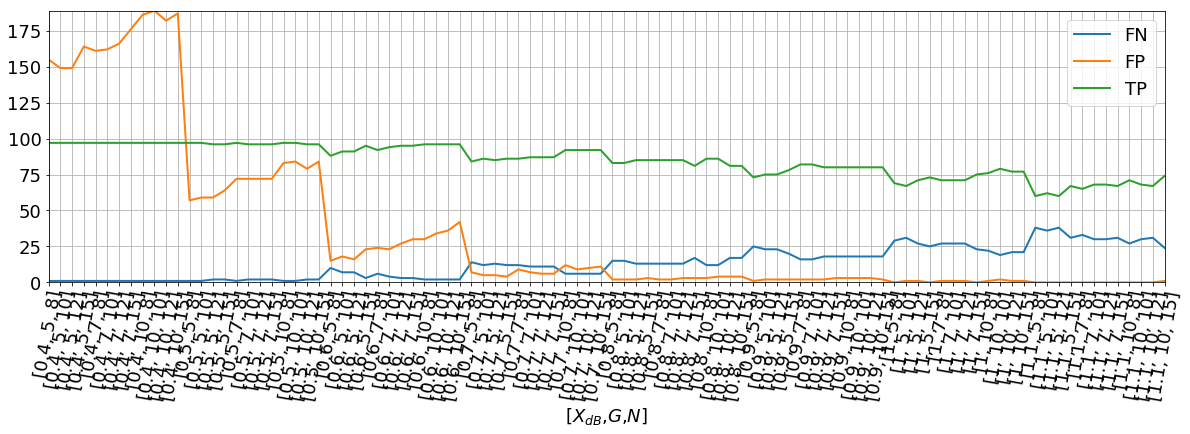

In [17]:
n = 25
f_min, f_max = 4.5, 11.5
N,G,k,Ts,Tl,X_dB = 10,7,0,0,0,0.5
# N,G,k,Ts,Tl,X_dB = 10,7,9,0,0,0.5

# for X_dB in [0.4,0.5,0.6,0.7,0.8,0.9,1,1.1]:
#     for G in [5,7,10]:
#         for N in [8,10,12,15]:
#             cfar_detector_gen.dataset_cross_correlation_gen(transforms='zscore', transforms_params=None, f_min=f_min, f_max=f_max, 
#                                            An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
#                                            train=True, n=n)
x_axis = []
recall, precision, f1_score = [],[],[]
TP,FP, FN = [],[],[]
results = {}
# for X_dB in [0.4,0.5,0.6,0.7]:
#     for G in [5,7,10]:
#         for N in [8,10,12,15]:
#             print([N,G,X_dB])
for X_dB in [0.4,0.5,0.6,0.7,0.8,0.9,1,1.1]:
    for G in [5,7,10]:
        for N in [8,10,12,15]:
            data = cfar_detector_gen.dataset_cross_correlation_load(transforms='zscore', transforms_params=None, f_min=f_min, f_max=f_max, 
                                           An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
                                           train=True, n=n)
            confusion_matrix = data['confusion matrix']
            x_axis.append([X_dB,G,N])
            results[str([X_dB,G,N])]=confusion_matrix
            TP.append(confusion_matrix[0])
            FP.append(confusion_matrix[1])
            FN.append(confusion_matrix[2])
            performance = cfar_detector_gen.performance(confusion_matrix)
            recall.append(performance['recall'])
            precision.append(performance['precision'])
            f1_score.append(performance['f1 score'])
#             print(performance)
plt.figure(figsize=(20,5))
plt.plot(precision,linewidth=font[-1])
plt.plot(recall,linewidth=font[-1])
plt.plot(f1_score,linewidth=font[-1])
plt.xticks(list(range(len(x_axis))),x_axis, rotation=80, fontsize=font[3])
plt.yticks(fontsize=font[3])
plt.legend(['precision','recall','f1 score'], fontsize=font[3])
plt.xlabel('[$X_{dB}$,$G$,$N$]', fontsize=font[3])
plt.autoscale(tight=True)
plt.grid(True)
plt.show()
plt.figure(figsize=(20,5))
plt.plot(FN,linewidth=font[-1])
plt.plot(FP,linewidth=font[-1])
plt.plot(TP,linewidth=font[-1])
plt.xticks(list(range(len(x_axis))),x_axis, rotation=80, fontsize=font[3])
plt.yticks(fontsize=font[3])
plt.legend(['FN','FP','TP'], fontsize=font[3])
plt.xlabel('[$X_{dB}$,$G$,$N$]', fontsize=font[3])
plt.autoscale(tight=True)
plt.grid(True)
plt.show()

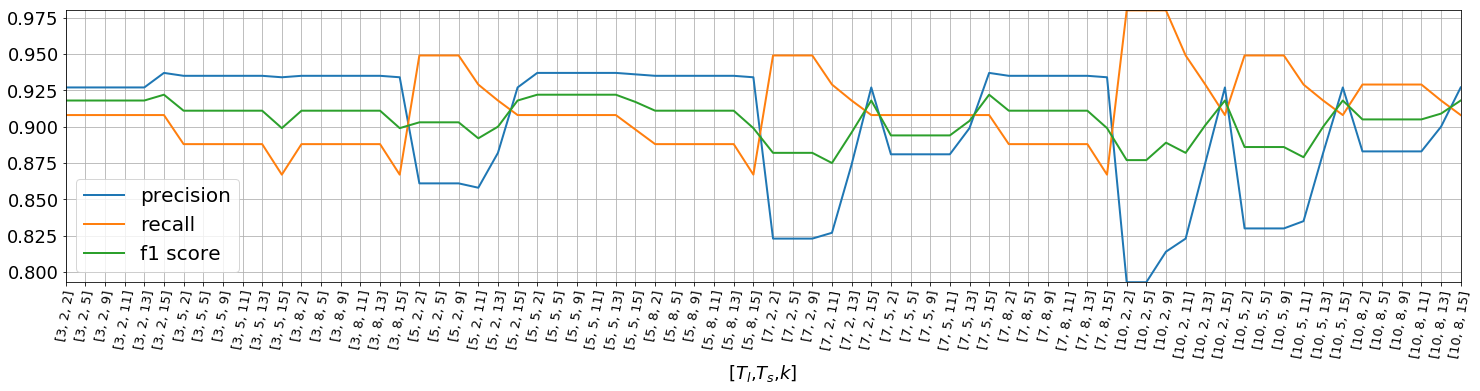

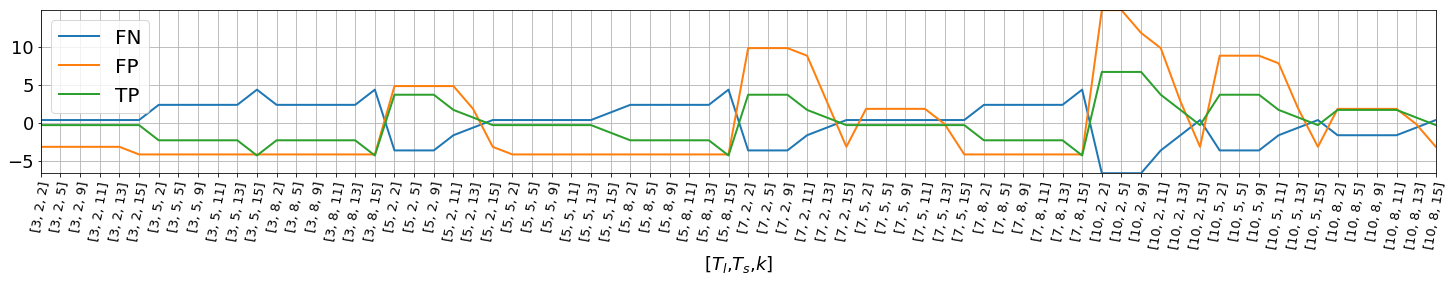

In [19]:
n = 25
f_min, f_max = 4.5, 11.5
N,G,k,Ts,Tl,X_dB = 15,7,0,0,0,0.7

# for Tl in [3,5,7,10]:
#     for Ts in [2,5,8]:
#         for k in [2,5,9,11,13,15]:
#             cfar_detector_gen.dataset_cross_correlation_gen(transforms='zscore', transforms_params=None, f_min=f_min, f_max=f_max, 
#                                            An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
#                                            train=True, n=n)
x_axis = []
recall, precision, f1_score = [],[],[]
TP,FP, FN = [],[],[]
for Tl in [3,5,7,10]:
    for Ts in [2,5,8]:
        for k in [2,5,9,11,13,15]:
            x_axis.append([Tl,Ts,k])
            data = cfar_detector_gen.dataset_cross_correlation_load(transforms='zscore', transforms_params=None, f_min=f_min, f_max=f_max, 
                                           An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
                                           train=True, n=n)
            confusion_matrix = data['confusion matrix']
            TP.append(confusion_matrix[0])
            FP.append(confusion_matrix[1])
            FN.append(confusion_matrix[2])
            performance = cfar_detector_gen.performance(confusion_matrix)
            recall.append(performance['recall'])
            precision.append(performance['precision'])
            f1_score.append(performance['f1 score'])
TP, FP, FN = np.array(TP),np.array(FP),np.array(FN)
TP, FP, FN = TP-TP.mean(),FP-FP.mean(),FN-FN.mean()

plt.figure(figsize=(25,5))
plt.plot(precision,linewidth=font[-1])
plt.plot(recall,linewidth=font[-1])
plt.plot(f1_score,linewidth=font[-1])
plt.xticks(list(range(len(x_axis))),x_axis, rotation=80, fontsize=font[3]-5)
plt.yticks(fontsize=font[3])
plt.legend(['precision','recall','f1 score'], fontsize=font[1])
plt.grid(True)
plt.autoscale(tight=True)
plt.xlabel('[$T_l$,$T_s$,$k$]', fontsize=font[3])
plt.show()
plt.figure(figsize=(25,3))
plt.plot(FN,linewidth=font[-1])
plt.plot(FP,linewidth=font[-1])
plt.plot(TP,linewidth=font[-1])
plt.xticks(list(range(len(x_axis))),x_axis, rotation=80, fontsize=font[3]-5)
plt.yticks(fontsize=font[3])
plt.legend(['FN','FP','TP'], fontsize=font[1])
plt.autoscale(tight=True)
plt.xlabel('[$T_l$,$T_s$,$k$]', fontsize=font[3])
plt.grid(True)
plt.show()

In [20]:
n = None
f_min, f_max = 4.5, 11.5
N,G,k,Ts,Tl,X_dB = 15,7,15,2,7,0.7
train = False
for train in [True, False]:
    cfar_detector_gen.dataset_cross_correlation_gen(transforms='zscore', transforms_params=None, f_min=f_min, f_max=f_max, 
                                               An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
                                               train=train, n=n)
    data = cfar_detector_gen.dataset_cross_correlation_load(transforms='zscore', transforms_params=None, f_min=f_min, f_max=f_max, 
                                               An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
                                               train=train, n=n)
    confusion_matrix = data['confusion matrix']
    performance = cfar_detector_gen.performance(confusion_matrix)
    print(confusion_matrix)
    print(performance)

100%|██████████| 1471/1471 [05:09<00:00,  4.90it/s]


[4887, 1026, 231, 0]
{'recall': 0.955, 'precision': 0.826, 'f1 score': 0.886, 'g measure': 0.888, 'false alarm': 0.174, 'misdetection': 0.045}


100%|██████████| 725/725 [02:33<00:00,  5.98it/s]


[2457, 458, 121, 0]
{'recall': 0.953, 'precision': 0.843, 'f1 score': 0.895, 'g measure': 0.896, 'false alarm': 0.157, 'misdetection': 0.047}


### detrend

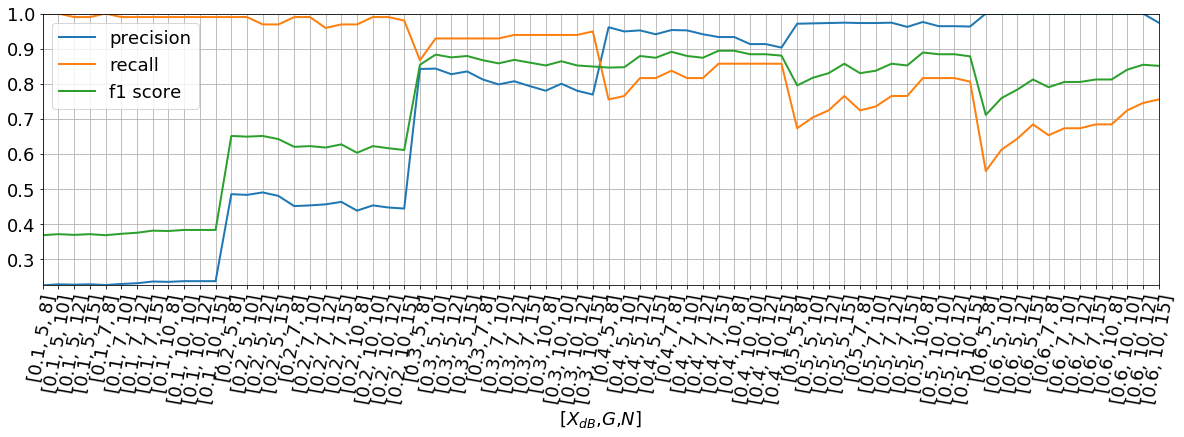

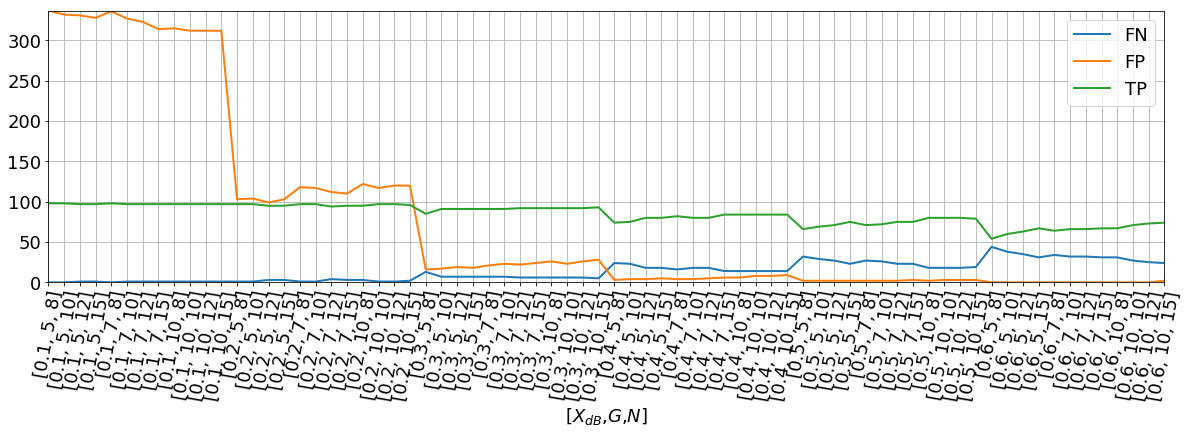

In [26]:
n = 25
f_min, f_max = 1.5, 9.5
N,G,k,Ts,Tl,X_dB = 10,7,0,0,0,0.5
# N,G,k,Ts,Tl,X_dB = 10,7,9,0,0,0.5

# for X_dB in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1]:
#     for G in [5,7,10]:
#         for N in [8,10,12,15]:
#             cfar_detector_gen.dataset_cross_correlation_gen(transforms='detrend', transforms_params=['constant'], f_min=f_min, f_max=f_max, 
#                                            An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
#                                            train=True, n=n)
x_axis = []
recall, precision, f1_score = [],[],[]
TP,FP, FN = [],[],[]
results = {}
# for X_dB in [0.4,0.5,0.6,0.7]:
#     for G in [5,7,10]:
#         for N in [8,10,12,15]:
#             print([N,G,X_dB])
for X_dB in [0.1,0.2,0.3,0.4,0.5,0.6]:
    for G in [5,7,10]:
        for N in [8,10,12,15]:
            data = cfar_detector_gen.dataset_cross_correlation_load(transforms='detrend', transforms_params=['constant'], f_min=f_min, f_max=f_max, 
                                           An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
                                           train=True, n=n)
            confusion_matrix = data['confusion matrix']
            x_axis.append([X_dB,G,N])
            results[str([X_dB,G,N])]=confusion_matrix
            TP.append(confusion_matrix[0])
            FP.append(confusion_matrix[1])
            FN.append(confusion_matrix[2])
            performance = cfar_detector_gen.performance(confusion_matrix)
            recall.append(performance['recall'])
            precision.append(performance['precision'])
            f1_score.append(performance['f1 score'])
#             print(performance)
plt.figure(figsize=(20,5))
plt.plot(precision,linewidth=font[-1])
plt.plot(recall,linewidth=font[-1])
plt.plot(f1_score,linewidth=font[-1])
plt.xticks(list(range(len(x_axis))),x_axis, rotation=80, fontsize=font[3])
plt.yticks(fontsize=font[3])
plt.legend(['precision','recall','f1 score'], fontsize=font[3])
plt.xlabel('[$X_{dB}$,$G$,$N$]', fontsize=font[3])
plt.autoscale(tight=True)
plt.grid(True)
plt.show()
plt.figure(figsize=(20,5))
plt.plot(FN,linewidth=font[-1])
plt.plot(FP,linewidth=font[-1])
plt.plot(TP,linewidth=font[-1])
plt.xticks(list(range(len(x_axis))),x_axis, rotation=80, fontsize=font[3])
plt.yticks(fontsize=font[3])
plt.legend(['FN','FP','TP'], fontsize=font[3])
plt.xlabel('[$X_{dB}$,$G$,$N$]', fontsize=font[3])
plt.autoscale(tight=True)
plt.grid(True)
plt.show()

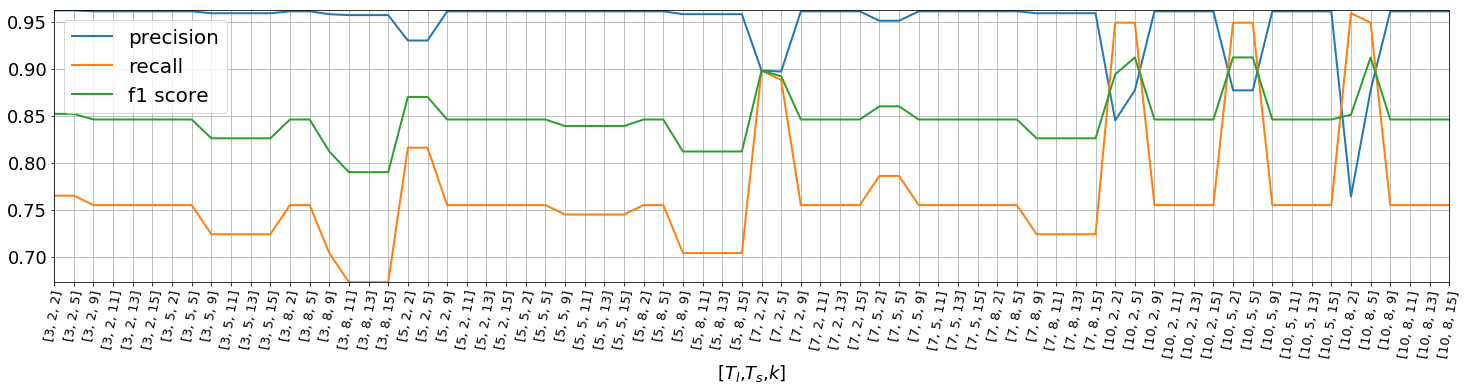

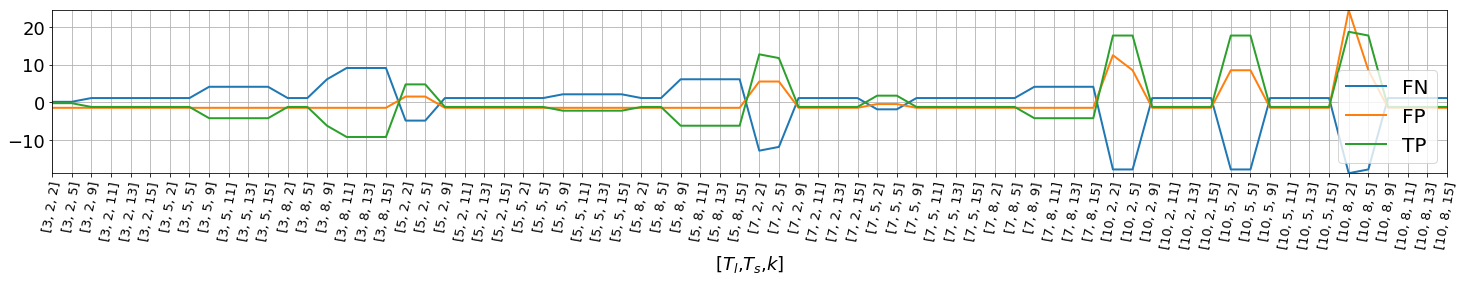

In [28]:
n = 25
f_min, f_max = 1.5, 9.5
N,G,k,Ts,Tl,X_dB = 8,5,0,0,0,0.4

# for Tl in [3,5,7,10]:
#     for Ts in [2,5,8]:
#         for k in [2,5,9,11,13,15]:
#             cfar_detector_gen.dataset_cross_correlation_gen(transforms='detrend', transforms_params=['constant'], f_min=f_min, f_max=f_max, 
#                                            An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
#                                            train=True, n=n)
x_axis = []
recall, precision, f1_score = [],[],[]
TP,FP, FN = [],[],[]
for Tl in [3,5,7,10]:
    for Ts in [2,5,8]:
        for k in [2,5,9,11,13,15]:
            x_axis.append([Tl,Ts,k])
            data = cfar_detector_gen.dataset_cross_correlation_load(transforms='detrend', transforms_params=['constant'], f_min=f_min, f_max=f_max, 
                                           An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
                                           train=True, n=n)
            confusion_matrix = data['confusion matrix']
            TP.append(confusion_matrix[0])
            FP.append(confusion_matrix[1])
            FN.append(confusion_matrix[2])
            performance = cfar_detector_gen.performance(confusion_matrix)
            recall.append(performance['recall'])
            precision.append(performance['precision'])
            f1_score.append(performance['f1 score'])
TP, FP, FN = np.array(TP),np.array(FP),np.array(FN)
TP, FP, FN = TP-TP.mean(),FP-FP.mean(),FN-FN.mean()

plt.figure(figsize=(25,5))
plt.plot(precision,linewidth=font[-1])
plt.plot(recall,linewidth=font[-1])
plt.plot(f1_score,linewidth=font[-1])
plt.xticks(list(range(len(x_axis))),x_axis, rotation=80, fontsize=font[3]-5)
plt.yticks(fontsize=font[3])
plt.legend(['precision','recall','f1 score'], fontsize=font[1])
plt.grid(True)
plt.autoscale(tight=True)
plt.xlabel('[$T_l$,$T_s$,$k$]', fontsize=font[3])
plt.show()
plt.figure(figsize=(25,3))
plt.plot(FN,linewidth=font[-1])
plt.plot(FP,linewidth=font[-1])
plt.plot(TP,linewidth=font[-1])
plt.xticks(list(range(len(x_axis))),x_axis, rotation=80, fontsize=font[3]-5)
plt.yticks(fontsize=font[3])
plt.legend(['FN','FP','TP'], fontsize=font[1])
plt.autoscale(tight=True)
plt.xlabel('[$T_l$,$T_s$,$k$]', fontsize=font[3])
plt.grid(True)
plt.show()

In [5]:
n = None
f_min, f_max = 1.5, 9.5
N,G,k,Ts,Tl,X_dB = 8,5,5,0,7,0.4
train = False
for train in [True, False]:
    cfar_detector_gen.dataset_cross_correlation_gen(transforms='detrend', transforms_params=['constant'], f_min=f_min, f_max=f_max, 
                                               An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
                                               train=train, n=n)
    data = cfar_detector_gen.dataset_cross_correlation_load(transforms='detrend', transforms_params=['constant'], f_min=f_min, f_max=f_max, 
                                               An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
                                               train=train, n=n)
    confusion_matrix = data['confusion matrix']
    performance = cfar_detector_gen.performance(confusion_matrix)
    print(confusion_matrix)
    print(performance)

100%|██████████| 1471/1471 [05:15<00:00,  4.06it/s]


[4800, 907, 318, 0]
{'recall': 0.938, 'precision': 0.841, 'f1 score': 0.887, 'g measure': 0.888, 'false alarm': 0.159, 'misdetection': 0.062}


100%|██████████| 725/725 [02:31<00:00,  4.78it/s]


[2408, 413, 170, 0]
{'recall': 0.934, 'precision': 0.854, 'f1 score': 0.892, 'g measure': 0.893, 'false alarm': 0.146, 'misdetection': 0.066}


### detrend linear

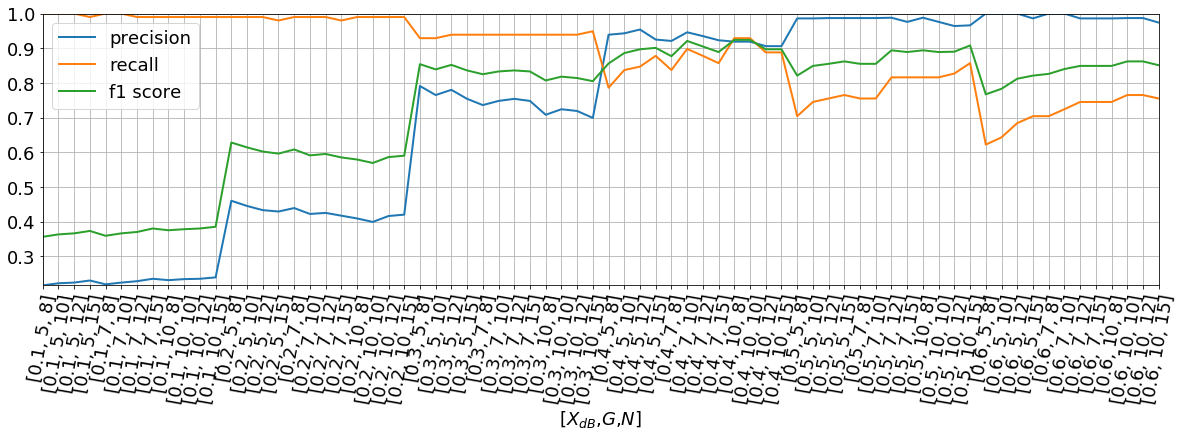

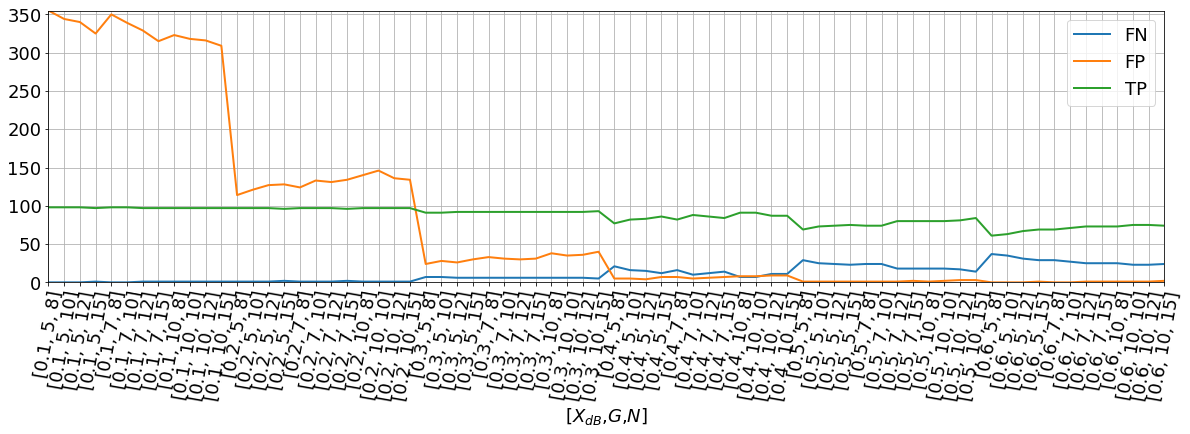

In [32]:
n = 25
f_min, f_max = 1.5, 9.5
N,G,k,Ts,Tl,X_dB = 10,7,0,0,0,0.5
# N,G,k,Ts,Tl,X_dB = 10,7,9,0,0,0.5

# for X_dB in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1]:
#     for G in [5,7,10]:
#         for N in [8,10,12,15]:
#             cfar_detector_gen.dataset_cross_correlation_gen(transforms='detrend', transforms_params=['linear'], f_min=f_min, f_max=f_max, 
#                                            An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
#                                            train=True, n=n)
x_axis = []
recall, precision, f1_score = [],[],[]
TP,FP, FN = [],[],[]
results = {}
# for X_dB in [0.4,0.5,0.6,0.7]:
#     for G in [5,7,10]:
#         for N in [8,10,12,15]:
#             print([N,G,X_dB])

for X_dB in [0.1,0.2,0.3,0.4,0.5,0.6]:
    for G in [5,7,10]:
        for N in [8,10,12,15]:
            data = cfar_detector_gen.dataset_cross_correlation_load(transforms='detrend', transforms_params=['linear'], f_min=f_min, f_max=f_max, 
                                           An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
                                           train=True, n=n)
            confusion_matrix = data['confusion matrix']
            x_axis.append([X_dB,G,N])
            results[str([X_dB,G,N])]=confusion_matrix
            TP.append(confusion_matrix[0])
            FP.append(confusion_matrix[1])
            FN.append(confusion_matrix[2])
            performance = cfar_detector_gen.performance(confusion_matrix)
            recall.append(performance['recall'])
            precision.append(performance['precision'])
            f1_score.append(performance['f1 score'])
#             print(performance)
plt.figure(figsize=(20,5))
plt.plot(precision,linewidth=font[-1])
plt.plot(recall,linewidth=font[-1])
plt.plot(f1_score,linewidth=font[-1])
plt.xticks(list(range(len(x_axis))),x_axis, rotation=80, fontsize=font[3])
plt.yticks(fontsize=font[3])
plt.legend(['precision','recall','f1 score'], fontsize=font[3])
plt.xlabel('[$X_{dB}$,$G$,$N$]', fontsize=font[3])
plt.autoscale(tight=True)
plt.grid(True)
plt.show()
plt.figure(figsize=(20,5))
plt.plot(FN,linewidth=font[-1])
plt.plot(FP,linewidth=font[-1])
plt.plot(TP,linewidth=font[-1])
plt.xticks(list(range(len(x_axis))),x_axis, rotation=80, fontsize=font[3])
plt.yticks(fontsize=font[3])
plt.legend(['FN','FP','TP'], fontsize=font[3])
plt.xlabel('[$X_{dB}$,$G$,$N$]', fontsize=font[3])
plt.autoscale(tight=True)
plt.grid(True)
plt.show()

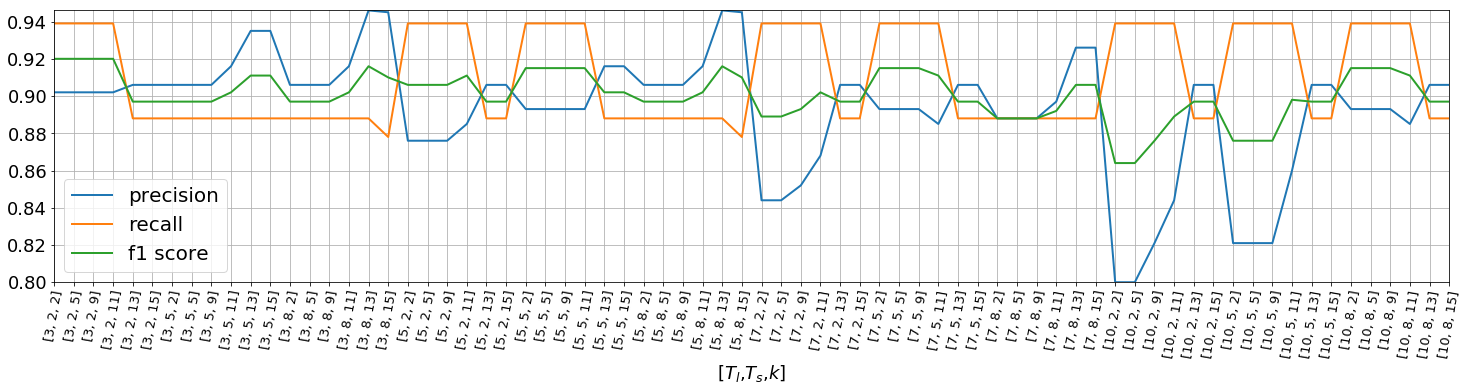

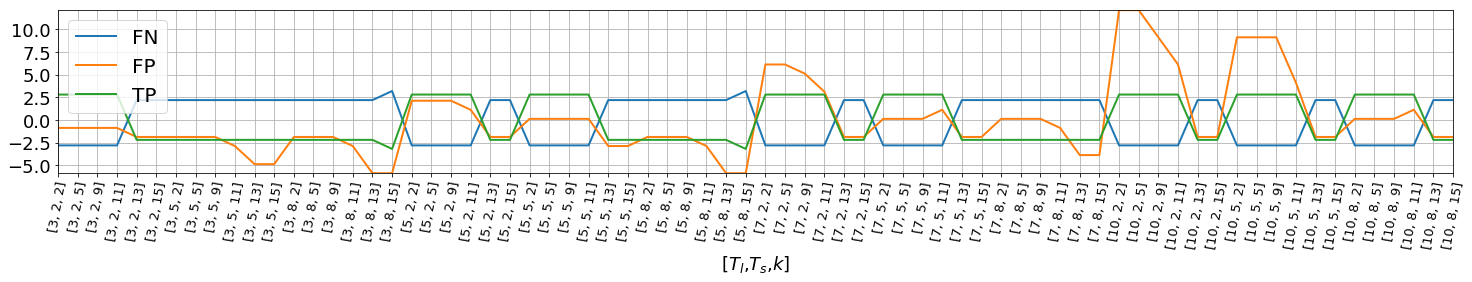

In [34]:
n = 25
f_min, f_max = 1.5, 9.5
N,G,k,Ts,Tl,X_dB = 12,10,0,0,0,0.4

# for Tl in [3,5,7,10]:
#     for Ts in [2,5,8]:
#         for k in [2,5,9,11,13,15]:
#             cfar_detector_gen.dataset_cross_correlation_gen(transforms='detrend', transforms_params=['linear'], f_min=f_min, f_max=f_max, 
#                                            An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
#                                            train=True, n=n)
x_axis = []
recall, precision, f1_score = [],[],[]
TP,FP, FN = [],[],[]
for Tl in [3,5,7,10]:
    for Ts in [2,5,8]:
        for k in [2,5,9,11,13,15]:
            x_axis.append([Tl,Ts,k])
            data = cfar_detector_gen.dataset_cross_correlation_load(transforms='detrend', transforms_params=['linear'], f_min=f_min, f_max=f_max, 
                                           An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
                                           train=True, n=n)
            confusion_matrix = data['confusion matrix']
            TP.append(confusion_matrix[0])
            FP.append(confusion_matrix[1])
            FN.append(confusion_matrix[2])
            performance = cfar_detector_gen.performance(confusion_matrix)
            recall.append(performance['recall'])
            precision.append(performance['precision'])
            f1_score.append(performance['f1 score'])
TP, FP, FN = np.array(TP),np.array(FP),np.array(FN)
TP, FP, FN = TP-TP.mean(),FP-FP.mean(),FN-FN.mean()

plt.figure(figsize=(25,5))
plt.plot(precision,linewidth=font[-1])
plt.plot(recall,linewidth=font[-1])
plt.plot(f1_score,linewidth=font[-1])
plt.xticks(list(range(len(x_axis))),x_axis, rotation=80, fontsize=font[3]-5)
plt.yticks(fontsize=font[3])
plt.legend(['precision','recall','f1 score'], fontsize=font[1])
plt.grid(True)
plt.autoscale(tight=True)
plt.xlabel('[$T_l$,$T_s$,$k$]', fontsize=font[3])
plt.show()
plt.figure(figsize=(25,3))
plt.plot(FN,linewidth=font[-1])
plt.plot(FP,linewidth=font[-1])
plt.plot(TP,linewidth=font[-1])
plt.xticks(list(range(len(x_axis))),x_axis, rotation=80, fontsize=font[3]-5)
plt.yticks(fontsize=font[3])
plt.legend(['FN','FP','TP'], fontsize=font[1])
plt.autoscale(tight=True)
plt.xlabel('[$T_l$,$T_s$,$k$]', fontsize=font[3])
plt.grid(True)
plt.show()

In [36]:
n = None
f_min, f_max = 1.5, 9.5
N,G,k,Ts,Tl,X_dB = 12,10,13,8,5,0.4
train = False
for train in [True, False]:
    cfar_detector_gen.dataset_cross_correlation_gen(transforms='detrend', transforms_params=['linear'], f_min=f_min, f_max=f_max, 
                                               An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
                                               train=train, n=n)
    data = cfar_detector_gen.dataset_cross_correlation_load(transforms='detrend', transforms_params=['linear'], f_min=f_min, f_max=f_max, 
                                               An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
                                               train=train, n=n)
    confusion_matrix = data['confusion matrix']
    performance = cfar_detector_gen.performance(confusion_matrix)
    print(confusion_matrix)
    print(performance)

100%|██████████| 1471/1471 [05:36<00:00,  3.01it/s]


[4670, 662, 448, 0]
{'recall': 0.912, 'precision': 0.876, 'f1 score': 0.894, 'g measure': 0.894, 'false alarm': 0.124, 'misdetection': 0.088}


100%|██████████| 725/725 [02:44<00:00,  6.24it/s]


[2357, 308, 221, 0]
{'recall': 0.914, 'precision': 0.884, 'f1 score': 0.899, 'g measure': 0.899, 'false alarm': 0.116, 'misdetection': 0.086}


## No transform

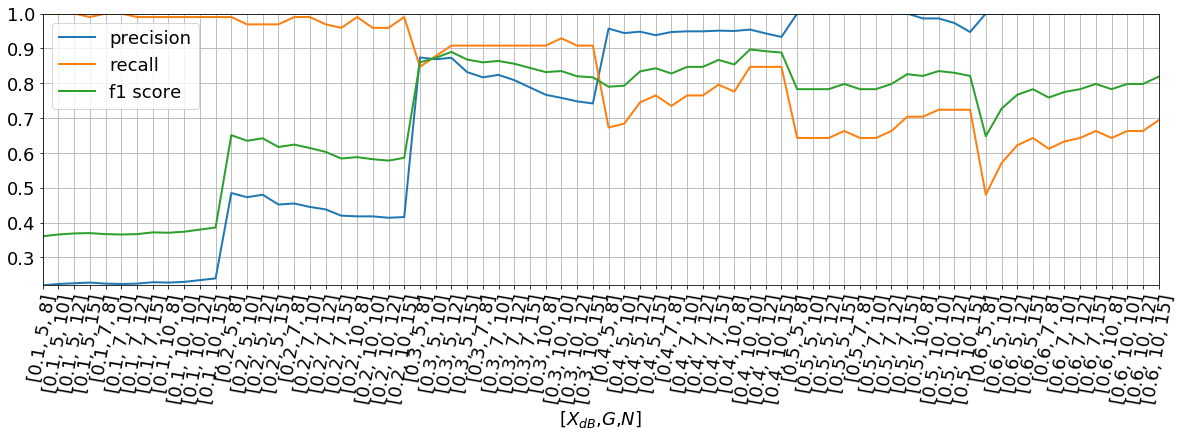

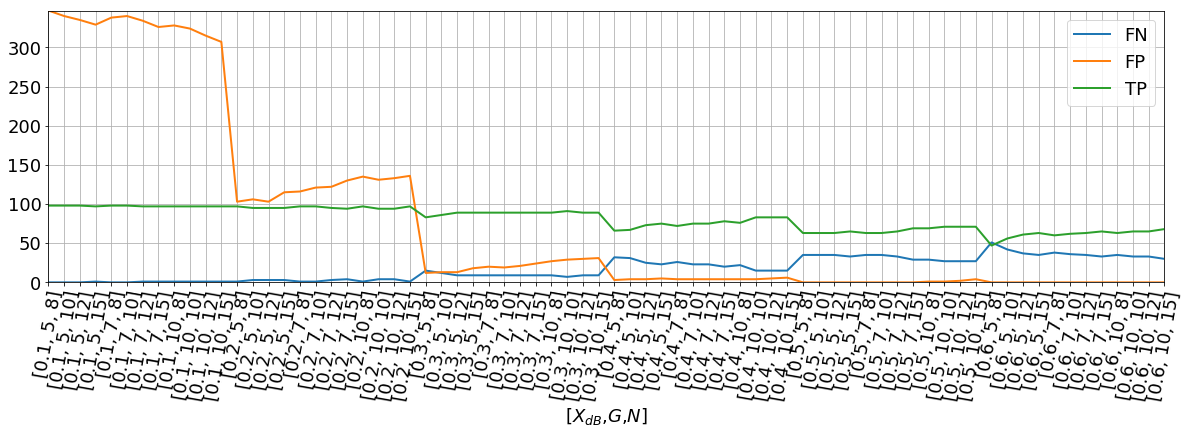

In [39]:
n = 25
f_min, f_max = 1.5, 9.5
N,G,k,Ts,Tl,X_dB = 10,7,0,0,0,0.5
# N,G,k,Ts,Tl,X_dB = 10,7,9,0,0,0.5

# for X_dB in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1]:
#     for G in [5,7,10]:
#         for N in [8,10,12,15]:
#             cfar_detector_gen.dataset_cross_correlation_gen(transforms=None, transforms_params=None, f_min=f_min, f_max=f_max, 
#                                            An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
#                                            train=True, n=n)
x_axis = []
recall, precision, f1_score = [],[],[]
TP,FP, FN = [],[],[]
results = {}
# for X_dB in [0.4,0.5,0.6,0.7]:
#     for G in [5,7,10]:
#         for N in [8,10,12,15]:
#             print([N,G,X_dB])

for X_dB in [0.1,0.2,0.3,0.4,0.5,0.6]:
    for G in [5,7,10]:
        for N in [8,10,12,15]:
            data = cfar_detector_gen.dataset_cross_correlation_load(transforms=None, transforms_params=None, f_min=f_min, f_max=f_max, 
                                           An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
                                           train=True, n=n)
            confusion_matrix = data['confusion matrix']
            x_axis.append([X_dB,G,N])
            results[str([X_dB,G,N])]=confusion_matrix
            TP.append(confusion_matrix[0])
            FP.append(confusion_matrix[1])
            FN.append(confusion_matrix[2])
            performance = cfar_detector_gen.performance(confusion_matrix)
            recall.append(performance['recall'])
            precision.append(performance['precision'])
            f1_score.append(performance['f1 score'])
#             print(performance)
plt.figure(figsize=(20,5))
plt.plot(precision,linewidth=font[-1])
plt.plot(recall,linewidth=font[-1])
plt.plot(f1_score,linewidth=font[-1])
plt.xticks(list(range(len(x_axis))),x_axis, rotation=80, fontsize=font[3])
plt.yticks(fontsize=font[3])
plt.legend(['precision','recall','f1 score'], fontsize=font[3])
plt.xlabel('[$X_{dB}$,$G$,$N$]', fontsize=font[3])
plt.autoscale(tight=True)
plt.grid(True)
plt.show()
plt.figure(figsize=(20,5))
plt.plot(FN,linewidth=font[-1])
plt.plot(FP,linewidth=font[-1])
plt.plot(TP,linewidth=font[-1])
plt.xticks(list(range(len(x_axis))),x_axis, rotation=80, fontsize=font[3])
plt.yticks(fontsize=font[3])
plt.legend(['FN','FP','TP'], fontsize=font[3])
plt.xlabel('[$X_{dB}$,$G$,$N$]', fontsize=font[3])
plt.autoscale(tight=True)
plt.grid(True)
plt.show()

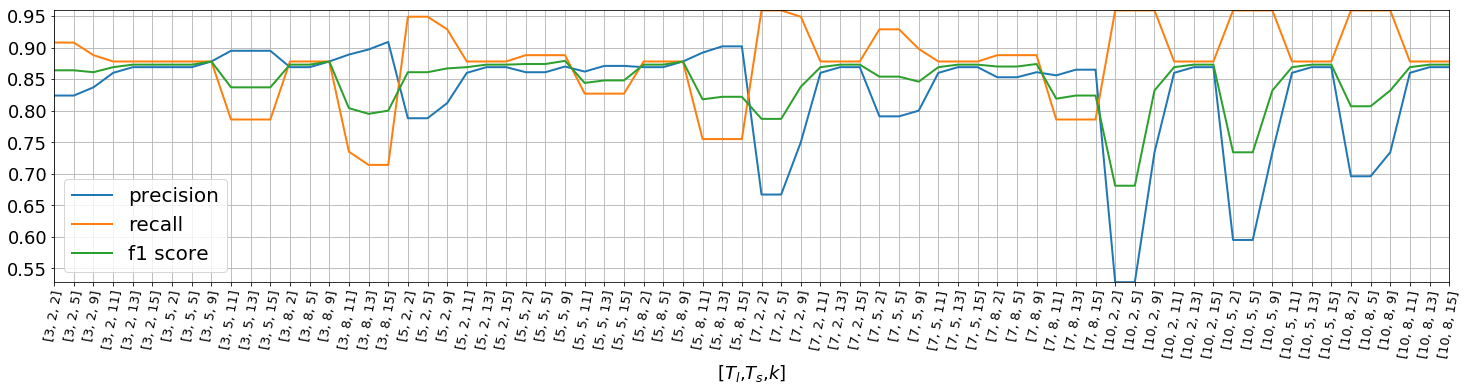

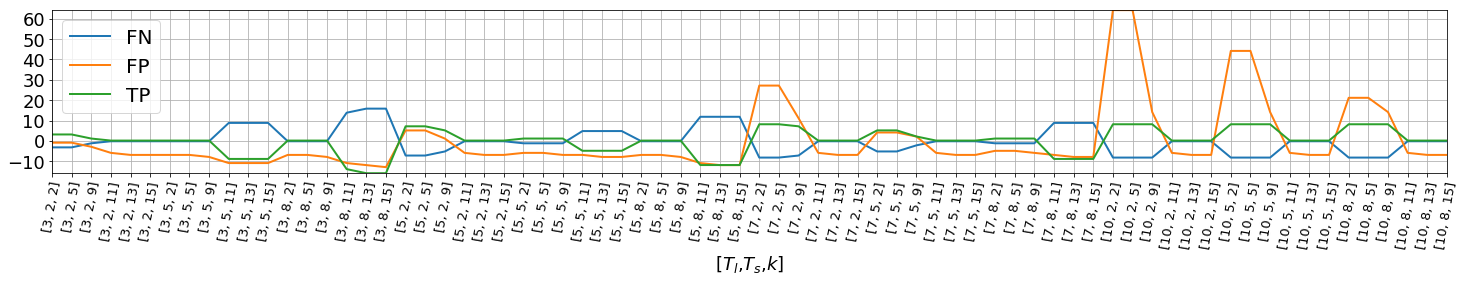

In [41]:
n = 25
f_min, f_max = 1.5, 9.5
N,G,k,Ts,Tl,X_dB = 10,5,0,0,0,0.3

# for Tl in [3,5,7,10]:
#     for Ts in [2,5,8]:
#         for k in [2,5,9,11,13,15]:
#             cfar_detector_gen.dataset_cross_correlation_gen(transforms=None, transforms_params=None, f_min=f_min, f_max=f_max, 
#                                            An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
#                                            train=True, n=n)
x_axis = []
recall, precision, f1_score = [],[],[]
TP,FP, FN = [],[],[]
for Tl in [3,5,7,10]:
    for Ts in [2,5,8]:
        for k in [2,5,9,11,13,15]:
            x_axis.append([Tl,Ts,k])
            data = cfar_detector_gen.dataset_cross_correlation_load(transforms=None, transforms_params=None, f_min=f_min, f_max=f_max, 
                                           An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
                                           train=True, n=n)
            confusion_matrix = data['confusion matrix']
            TP.append(confusion_matrix[0])
            FP.append(confusion_matrix[1])
            FN.append(confusion_matrix[2])
            performance = cfar_detector_gen.performance(confusion_matrix)
            recall.append(performance['recall'])
            precision.append(performance['precision'])
            f1_score.append(performance['f1 score'])
TP, FP, FN = np.array(TP),np.array(FP),np.array(FN)
TP, FP, FN = TP-TP.mean(),FP-FP.mean(),FN-FN.mean()

plt.figure(figsize=(25,5))
plt.plot(precision,linewidth=font[-1])
plt.plot(recall,linewidth=font[-1])
plt.plot(f1_score,linewidth=font[-1])
plt.xticks(list(range(len(x_axis))),x_axis, rotation=80, fontsize=font[3]-5)
plt.yticks(fontsize=font[3])
plt.legend(['precision','recall','f1 score'], fontsize=font[1])
plt.grid(True)
plt.autoscale(tight=True)
plt.xlabel('[$T_l$,$T_s$,$k$]', fontsize=font[3])
plt.show()
plt.figure(figsize=(25,3))
plt.plot(FN,linewidth=font[-1])
plt.plot(FP,linewidth=font[-1])
plt.plot(TP,linewidth=font[-1])
plt.xticks(list(range(len(x_axis))),x_axis, rotation=80, fontsize=font[3]-5)
plt.yticks(fontsize=font[3])
plt.legend(['FN','FP','TP'], fontsize=font[1])
plt.autoscale(tight=True)
plt.xlabel('[$T_l$,$T_s$,$k$]', fontsize=font[3])
plt.grid(True)
plt.show()

In [6]:
n = None
f_min, f_max = 1.5, 9.5
N,G,k,Ts,Tl,X_dB = 10,5,13,5,7,0.3
train = False
for train in [True, False]:
    cfar_detector_gen.dataset_cross_correlation_gen(transforms=None, transforms_params=None, f_min=f_min, f_max=f_max, 
                                               An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
                                               train=train, n=n)
    data = cfar_detector_gen.dataset_cross_correlation_load(transforms=None, transforms_params=None, f_min=f_min, f_max=f_max, 
                                               An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
                                               train=train, n=n)
    confusion_matrix = data['confusion matrix']
    performance = cfar_detector_gen.performance(confusion_matrix)
    print(confusion_matrix)
    print(performance)

100%|██████████| 1471/1471 [05:12<00:00,  4.16it/s]


[4649, 1155, 469, 0]
{'recall': 0.908, 'precision': 0.801, 'f1 score': 0.851, 'g measure': 0.853, 'false alarm': 0.199, 'misdetection': 0.092}


100%|██████████| 725/725 [02:41<00:00,  4.50it/s]


[2331, 541, 247, 0]
{'recall': 0.904, 'precision': 0.812, 'f1 score': 0.855, 'g measure': 0.857, 'false alarm': 0.188, 'misdetection': 0.096}
